Refer "Alpha in terms of time", "Limb Darkening", "Night Sky Coordinates of the Planet w.r.t the Star" notebooks for this

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import copy
import time
import random
from scipy.integrate import solve_ivp

np.set_printoptions(threshold=sys.maxsize)

In [17]:
def der_alpha(t, alpha, e): 
    return (2 * np.pi / (1 - e*e)**1.5) * (1 + e*np.cos(alpha))**2

In [18]:
class system(object):
    def __init__(self, semi_major, eccentricity, periastron_angle, inclination, star_radius, \
                 planet_radius, Period, time_split=100, img_split=100):
        self.a_actual = semi_major
        self.e = eccentricity
        self.w = periastron_angle
        self.i = inclination
        self.Rs_actual = star_radius
        self.Rp_actual = planet_radius
        self.P_actual = Period
        self.time_split = int(time_split)
        self.split = int(img_split)
        self.u = [0.1, 0.2]

        self.a = self.a_actual/self.Rs_actual
        self.Rp = self.Rp_actual/self.Rs_actual
        self.Rs = 1.0
        self.P = 1.0
        
        self.init_alpha_wrt_time()
        self.init_stellar_limb_darkening()
        
        
    def init_alpha_wrt_time(self):
        t_span = (0, 1)
        t = np.linspace(0, 1, self.time_split+1)
        y0 = np.array([0])
        sol = solve_ivp(der_alpha, t_span, y0, t_eval = t, args = (self.e,))
        print(sol.y[0][0], sol.y[0][1], sol.y[0][-1])
        self.alpha_array = sol.y[0]
        self.time_array = sol.t

        
    def init_stellar_limb_darkening(self):
        self.star = np.zeros((2*self.split+1, 2*self.split+1))
        self.lum_total = 0
        for i in range(-self.split, self.split+1):
            rg_j = abs(int((self.split**2 - i**2)**0.5))
            for j in range(-rg_j, rg_j+1):
                x = (i)/self.split
                y = (j)/self.split
                cosine = abs((1 - x**2 - y**2)**0.5)
                lum = 1 - self.u[0]*(1 - cosine) - self.u[1]*((1 - cosine)**2)
                self.lum_total += lum
                self.star[self.split+i][self.split+j] = lum


    def output(self, time):
        t = (time/self.P_actual) % 1
        n = time * self.time_split
        alpha = self.alpha_array[int(n)]
        
        angle = alpha + self.w
        r = self.a * (1 - self.e**2) / (1 + self.e*np.cos(alpha))
        orig_x = r * np.cos(angle)
        orig_y = r * np.sin(angle) * np.cos(self.i)
        
        if orig_y*(self.i - (np.pi/2)) > 0: # Only the part of orbit which is away from us
            return self.lum_total
        if orig_x**2 + orig_y**2 > 2*((1+self.Rp)**2):
            return self.lum_total
        cur_star = copy.deepcopy(self.star)
        cur_total = copy.deepcopy(self.lum_total)
        x, y, Rp = int(orig_x*self.split), int(orig_y*self.split), int(self.Rp*self.split)
        for i in range(-Rp, Rp+1):
            if y-i >= -self.split and y-i <= self.split:
                rg_j = abs(int((Rp**2 - i**2)**0.5))
                for j in range(-rg_j, rg_j+1):
                    if x+j >= -self.split and x+j <= self.split:
                        m = self.split - y + i
                        n = self.split + x + j
                        lum = cur_star[m][n]
                        cur_total -= lum
                        cur_star[m][n] = 0
        return cur_total

In [19]:
print(time.localtime())
exo = system(semi_major = 26, \
             eccentricity = 0 , \
             periastron_angle = 200*(np.pi/180) , \
             inclination = 89.9*(np.pi/180), \
             # Never put 90.
             star_radius = 1.0, \
             planet_radius = 0.1, \
             Period = 17.2, \
             time_split = 10000, \
             img_split = 1000)
times = exo.time_array
print(time.localtime())

time.struct_time(tm_year=2020, tm_mon=6, tm_mday=28, tm_hour=23, tm_min=33, tm_sec=46, tm_wday=6, tm_yday=180, tm_isdst=0)
0.0 0.0006283185307179587 6.283185307179596
time.struct_time(tm_year=2020, tm_mon=6, tm_mday=28, tm_hour=23, tm_min=33, tm_sec=49, tm_wday=6, tm_yday=180, tm_isdst=0)


In [20]:
print(time.localtime())
total_lum = exo.lum_total
lum = []
for t in times:
    lum.append(exo.output(t))
lum = np.array(lum)/total_lum
print(time.localtime())

time.struct_time(tm_year=2020, tm_mon=6, tm_mday=28, tm_hour=23, tm_min=33, tm_sec=49, tm_wday=6, tm_yday=180, tm_isdst=0)
time.struct_time(tm_year=2020, tm_mon=6, tm_mday=28, tm_hour=23, tm_min=33, tm_sec=54, tm_wday=6, tm_yday=180, tm_isdst=0)


time.struct_time(tm_year=2020, tm_mon=6, tm_mday=28, tm_hour=23, tm_min=33, tm_sec=54, tm_wday=6, tm_yday=180, tm_isdst=0)
time.struct_time(tm_year=2020, tm_mon=6, tm_mday=28, tm_hour=23, tm_min=33, tm_sec=54, tm_wday=6, tm_yday=180, tm_isdst=0)


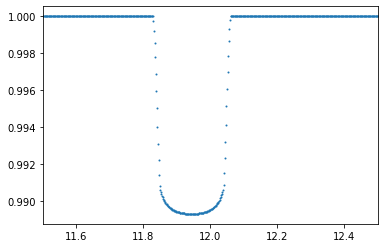

In [21]:
print(time.localtime())
plt.scatter(times*exo.P_actual, lum, s=1)
plt.xlim(11.5,12.5)
print(time.localtime())

<font size="4">$3 + 5 + 1$ seconds for with the LC for time as $\frac{P}{10^5}$ and the LC in luminosity as $\frac{1}{10^6}$</font>